In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,GRF_Loss_phase_averaging,GRF_Loss_image_fitting,Spectra_Loss_MSE,Spectra_Loss_MAE

#Utils for handling jax
from jaxtronomy.GaussianRandomField.Jax_Utils import purify_function,jax_map,gradient_descent



# Universal font size
FS = 18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Lensing setup

In [2]:
#GRF true parameters
GRF_LogAmp=-7.
GRF_beta=2.
GRF_seed=1

GRF_params=[GRF_LogAmp,GRF_beta]

## Data grids

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [4]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [5]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [37]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

SNR=1000
kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': np.inf}
noise=Noise(npix, npix, **kwargs_noise)

parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

perturbed_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
unperturbed_image=simulate_smooth_image(kwargs_data,smooth_lens_image)

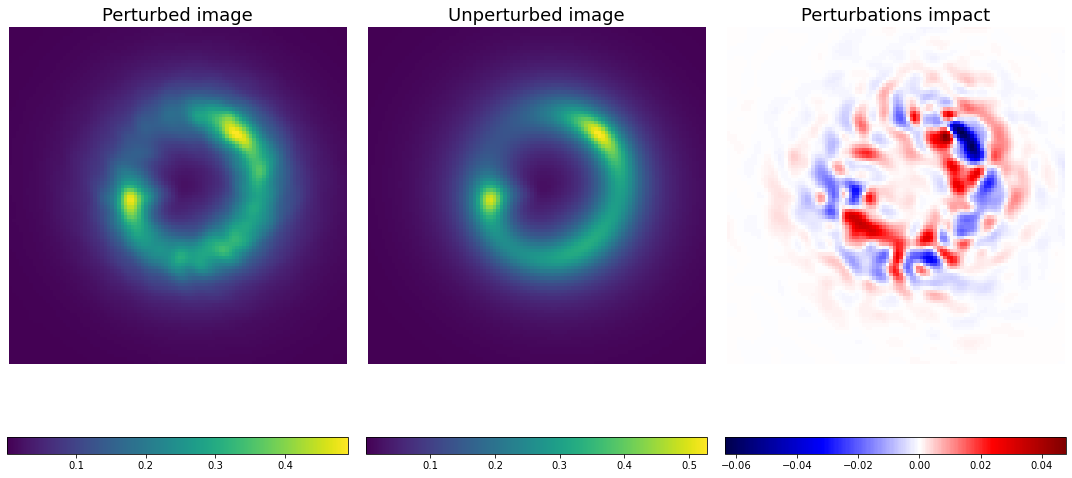

In [7]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(perturbed_image, origin='lower')
ax[0].set_title("Perturbed image", fontsize=FS)


im1=ax[1].imshow(unperturbed_image, origin='lower')
ax[1].set_title("Unperturbed image", fontsize=FS)


resid_true=perturbed_image-unperturbed_image
im2=ax[2].imshow(resid_true, origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Perturbations impact", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

## Einstein ring Mask

In [8]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

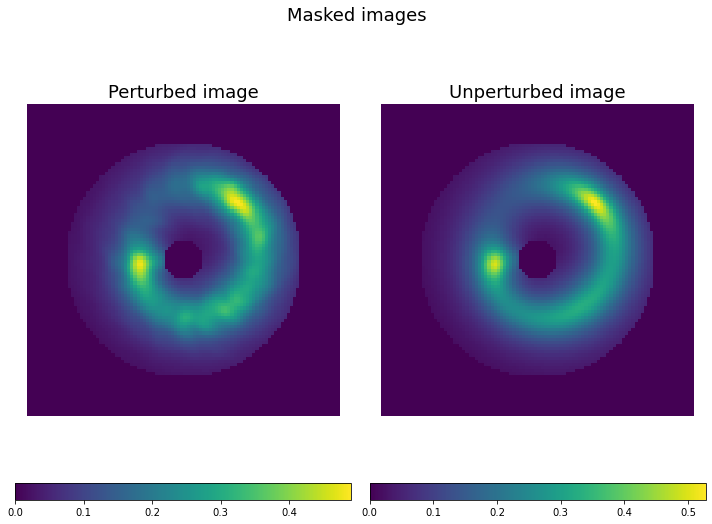

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(perturbed_image*mask, origin='lower')
ax1.set_title("Perturbed image", fontsize=FS)
img2 = ax2.imshow(unperturbed_image*mask, origin='lower')
ax2.set_title("Unperturbed image", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [10]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_data,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

# Target spectrum, Initial guess

In [11]:
#Compute Target Power spectrum of data residuals 
resid_true=perturbed_image-unperturbed_image
resid_true_spectrum=compute_radial_spectrum_pure(resid_true)

In [12]:
#First assumption is that power spectrum of GRF is close to power spectrum of residuals
#So fit the target power spectrum with a powerlaw to get an initial guess

def Powerlaw_spectrum(params,masked_k_vector):
  logA,Beta=params
  return np.power(10,logA)*np.power(masked_k_vector,-Beta)

def GRF_PS_loss(params,masked_k_vector,Target_spectrum):
  logA,Beta=params
  GRF_spectrum=Powerlaw_spectrum(params,masked_k_vector)
  MSE= np.power((Target_spectrum-GRF_spectrum)/Target_spectrum,2)
  return np.mean(MSE)

#Make a fit
res=scipy_minimize(GRF_PS_loss,x0=[0.,1.],args=(masked_k_vector,resid_true_spectrum))
GRF_init_guess=np.array(res.x)

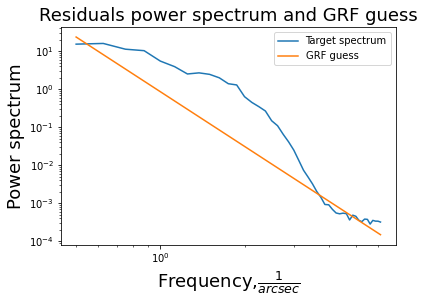

In [13]:
#Plot power spectrum and initial guess
plt.loglog(masked_k_vector,resid_true_spectrum,label='Target spectrum')
plt.loglog(masked_k_vector,Powerlaw_spectrum(GRF_init_guess,masked_k_vector),label='GRF guess')
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum and GRF guess',fontsize=FS)
plt.legend()
plt.show()

In [14]:
def compute_func_on_grid(GRF_Amps_array,GRF_Betas_array,func,output_size):
    res=np.zeros((len(GRF_Amps_array),len(GRF_Betas_array),output_size))

    for i in tqdm(range(100)):
        for j in range(100):
            res[i,j]=func([GRF_Amps_array[i],GRF_Betas_array[j]])
            
    return res

In [15]:
GRF_Amps_array_narrow=np.linspace(-7.05,-6.95,100)
GRF_Betas_array_narrow=np.linspace(1.5,2.5,100)

GRF_Amps_array_wide=np.linspace(-8.,-6.,100)
GRF_Betas_array_wide=np.linspace(0.5,3.5,100)

In [16]:
A_array=GRF_Amps_array_wide
Beta_array=GRF_Betas_array_wide

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)


num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

# GRF unknown args fitting

## Fitting Data to get a kwargs guess

In [198]:
smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)

DeviceArray([[ 0.0003498 ,  0.00132145,  0.00059946, ...,  0.00261544,
               0.00186377,  0.00150186],
             [ 0.0012776 ,  0.000602  , -0.00015777, ...,  0.0026856 ,
               0.00190366,  0.00245223],
             [ 0.0011229 ,  0.00082464,  0.00106828, ...,  0.00270723,
               0.00320416,  0.0026513 ],
             ...,
             [ 0.00145911,  0.00091868,  0.00118611, ...,  0.0026425 ,
               0.00197329,  0.00302937],
             [ 0.00210728,  0.00151398,  0.00144616, ...,  0.00190063,
               0.00233576,  0.00168756],
             [ 0.00186794,  0.00101705,  0.00223502, ...,  0.00226743,
               0.00170972,  0.00220462]], dtype=float64)

In [117]:
parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}$', '$y_{0}^{source}$']

def present_fit(kwargs_fit):
    fig,ax=plt.subplots(1,5,figsize=(20,7))

    im_arr=[]

    im=ax[0].imshow(perturbed_image,origin='lower')
    im_arr+=[im]
    ax[0].set_title('Data')

    im=ax[1].imshow(unperturbed_image,origin='lower')
    im_arr+=[im]
    ax[1].set_title('Model')

    fit_image=smooth_lens_image.model(**kwargs_fit)
    im=ax[2].imshow(fit_image,origin='lower')
    im_arr+=[im]
    ax[2].set_title('Fit')

    im=ax[3].imshow(perturbed_image-fit_image,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    im_arr+=[im]
    ax[3].set_title('Data-Fit')

    im=ax[4].imshow(unperturbed_image-fit_image,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    im_arr+=[im]
    ax[4].set_title('Model-Fit')


    for i in range(5):
        ax[i].axis('off')
        fig.colorbar(im_arr[i],ax=ax[i],orientation='horizontal')
    
    fig.tight_layout()
    plt.show()
    
    df=pd.DataFrame(columns=['parameter','true','error','rel_error'])

    df['parameter']=parameter_names
    df['true']=parameters.kwargs2args(kwargs_data)
    df['error']=df['true']-parameters.kwargs2args(kwargs_fit)
    df['rel_error']=df['error']/df['true']
    return df

In [139]:
kwargs_intermediate={'kwargs_lens': [{'theta_E': 1.5,'e1': 1e-3,'e2': 1e-3,'center_x': 1e-3,'center_y': 1e-3},{'gamma1': 1e-3, 'gamma2': 1e-3, 'ra_0': 0.0, 'dec_0': 0.0}],
                     'kwargs_source': [{'amp': 5.0,'R_sersic': 2.5,'n_sersic': 2.,'center_x': 0.,'center_y': 0.,'e1': 1e-3,'e2': 1e-3}],
                     'kwargs_lens_light': [{}]}


#present_fit(kwargs_intermediate)

In [140]:
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer


def fit_data(data,lens_image,parameters,method='BFGS'):

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method=method, restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))

  return kwargs_final

### Newton-CG is the best method for fitting

In [143]:
parameters=get_parameters(kwargs_intermediate,lens_mass_model_list,source_light_model_list)
#Fit with BFGS alg
kwargs_guess=fit_data(perturbed_image,smooth_lens_image,parameters,method='Newton-CG')

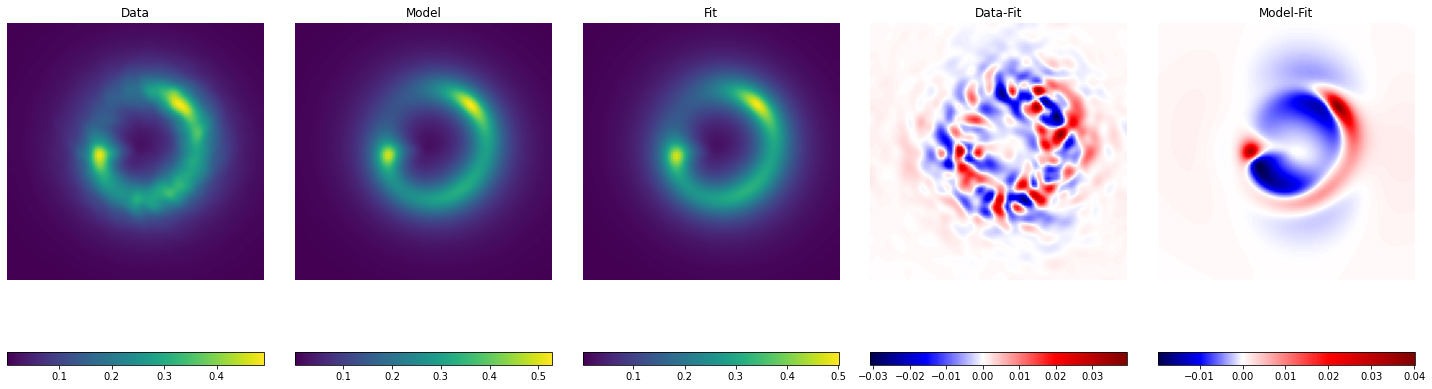

,parameter,true,error,rel_error
0,$\theta_{\rm E}$,1.60,0.010843,0.006777
1,$e_1^{lens}$,0.15,-0.012618,-0.084117
2,$e_2^{lens}$,-0.04,0.005492,-0.137299
3,$x_{0}^{lens}$,0.00,0.002417,inf
4,$y_{0}^{lens}$,0.00,0.008909,inf
5,"$\gamma_{\rm 1, ext}$",-0.01,-0.007183,0.718304
6,"$\gamma_{\rm 2, ext}$",0.03,0.004405,0.146840
7,$A$,10.00,-0.984128,-0.098413
8,$R_{\rm Sersic}$,1.20,0.062469,0.052057
9,$n_{\rm Sersic}$,1.50,0.128370,0.085580


In [144]:
present_fit(kwargs_fit)

## Fitting perturbed lens

In [181]:
GRF_sim=get_jaxified_GRF_pure(GRF_params,4)
simulated_image=simulate_perturbed_image_pure(GRF_sim)

In [182]:
args_guess=parameters.kwargs2args(kwargs_guess)

def impure_gradient_descent(gradient_function,initial_guess,max_iter,learning_rate):
    history=np.zeros((max_iter,len(initial_guess)))
    history[0]=initial_guess
    
    step_function= lambda X: X-learning_rate*gradient_function(X)
    
    for i in range(1,max_iter):
        history[i]=step_function(history[i-1])
        
    return history

In [183]:
model_loss_function_pure=purify_function(model_loss_function,simulated_image,parameters,simulate_smooth_image_pure)
model_loss_grad=jax.grad(model_loss_function_pure)

In [184]:
max_iter=500
learning_rate=5e-4

In [185]:
fit_history_3=impure_gradient_descent(model_loss_grad,args_guess,max_iter,1e-3)
fit_history_54=impure_gradient_descent(model_loss_grad,args_guess,max_iter,5e-4)
fit_history_4=impure_gradient_descent(model_loss_grad,args_guess,max_iter,1e-4)

In [186]:
loss_history_3=np.array([model_loss_function_pure(x) for x in fit_history_3])
loss_history_54=np.array([model_loss_function_pure(x) for x in fit_history_54])
loss_history_4=np.array([model_loss_function_pure(x) for x in fit_history_4])

In [165]:
image_fit_3=simulate_smooth_image_pure(parameters.args2kwargs(fit_history_3[-1]))
image_fit_54=simulate_smooth_image_pure(parameters.args2kwargs(fit_history_54[-1]))
image_fit_4=simulate_smooth_image_pure(parameters.args2kwargs(fit_history_4[-1]))

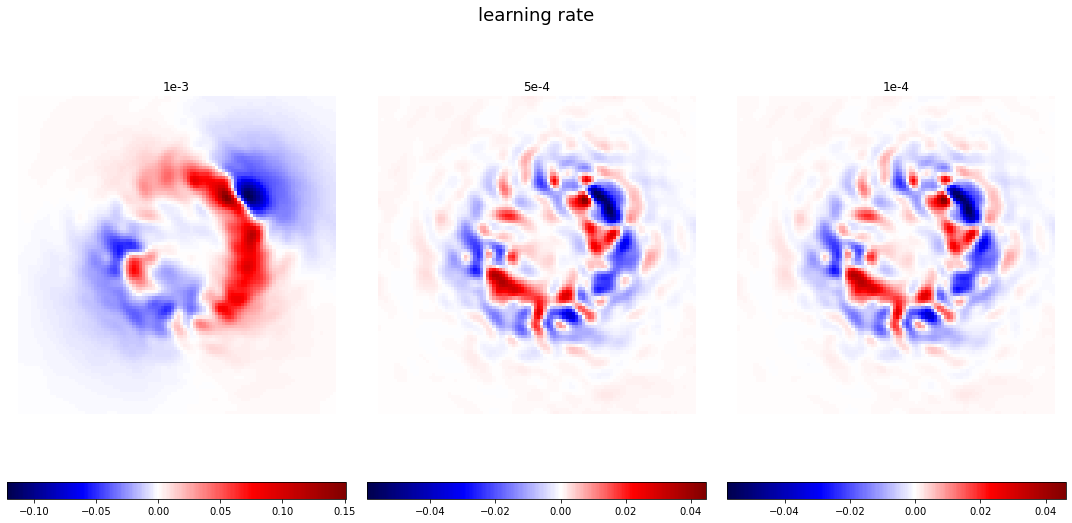

In [166]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

im0=ax[0].imshow(perturbed_image-image_fit_3,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].axis('off')
ax[0].set_title('1e-3')

im1=ax[1].imshow(perturbed_image-image_fit_54,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[1].axis('off')
ax[1].set_title('5e-4')

im2=ax[2].imshow(perturbed_image-image_fit_4,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].axis('off')
ax[2].set_title('1e-4')

fig.suptitle('learning rate',y=1.1,fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

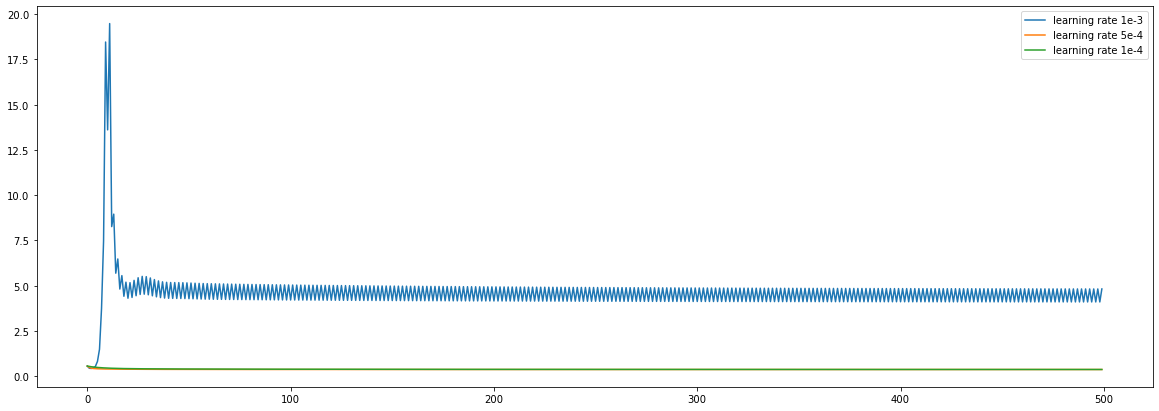

In [168]:
plt.figure(figsize=(20,7))
plt.plot(loss_history_3,label='learning rate 1e-3')
plt.plot(loss_history_54,label='learning rate 5e-4')
plt.plot(loss_history_4,label='learning rate 1e-4')
plt.legend()

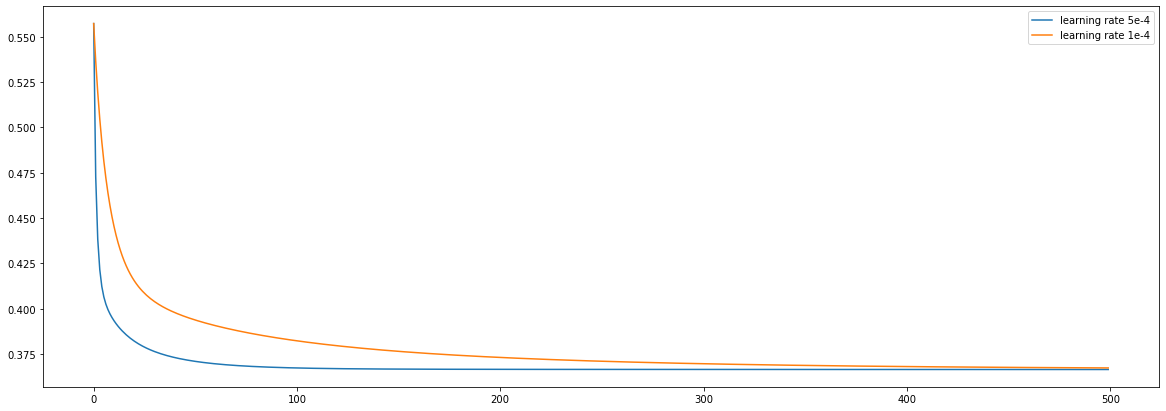

In [169]:
plt.figure(figsize=(20,7))
plt.plot(loss_history_54,label='learning rate 5e-4')
plt.plot(loss_history_4,label='learning rate 1e-4')
plt.legend()

### case of 3 different phases

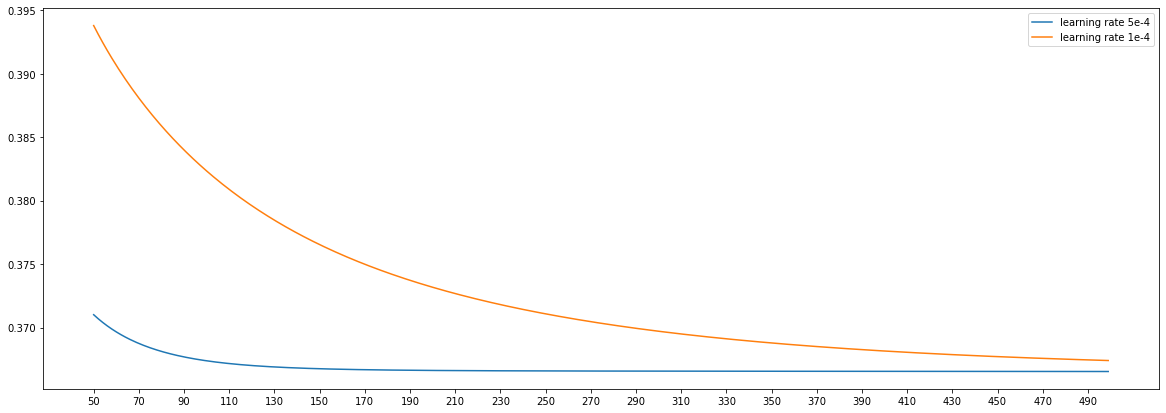

In [171]:
indent=50

plt.figure(figsize=(20,7))
plt.plot(loss_history_54[indent:],label='learning rate 5e-4')
plt.plot(loss_history_4[indent:],label='learning rate 1e-4')
ticks=np.arange(len(loss_history_54))
plt.xticks(ticks=ticks[:-indent][::20],labels=ticks[indent:][::20])
plt.legend()

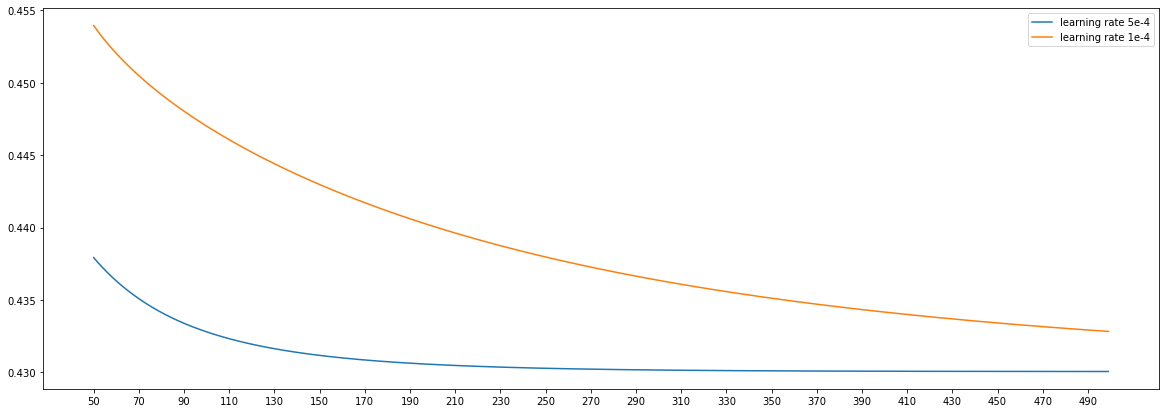

In [180]:
indent=50

plt.figure(figsize=(20,7))
plt.plot(loss_history_54[indent:],label='learning rate 5e-4')
plt.plot(loss_history_4[indent:],label='learning rate 1e-4')
ticks=np.arange(len(loss_history_54))
plt.xticks(ticks=ticks[:-indent][::20],labels=ticks[indent:][::20])
plt.legend()

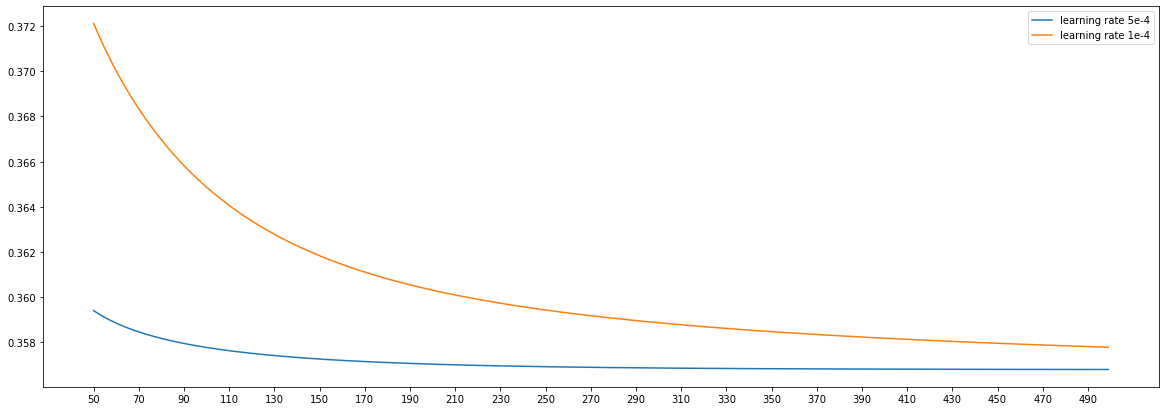

In [187]:
indent=50

plt.figure(figsize=(20,7))
plt.plot(loss_history_54[indent:],label='learning rate 5e-4')
plt.plot(loss_history_4[indent:],label='learning rate 1e-4')
ticks=np.arange(len(loss_history_54))
plt.xticks(ticks=ticks[:-indent][::20],labels=ticks[indent:][::20])
plt.legend()

In [306]:
#These fitting params should be enough
learning_rate=5e-4
max_iter=200

## Fitting observational data

In [192]:
model_loss_function_pure=purify_function(model_loss_function,perturbed_image,parameters,simulate_smooth_image_pure)
model_loss_grad=jax.grad(model_loss_function_pure)
#It's a cheat to start fitting from apriori unknown args_data, but I'll figure the initialising strategy out eventually
args_guess=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)

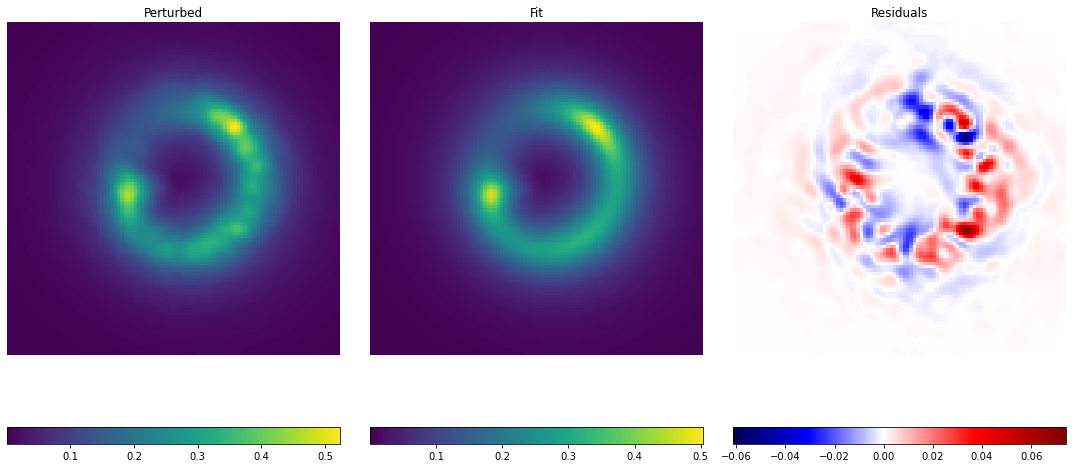

In [193]:
image_fit=simulate_smooth_image_pure(parameters.args2kwargs(args_guess))

fig,ax=plt.subplots(1,3,figsize=(15,7))

im0=ax[0].imshow(simulated_image,origin='lower')
ax[0].axis('off')
ax[0].set_title('Perturbed')

im1=ax[1].imshow(image_fit,origin='lower')
ax[1].axis('off')
ax[1].set_title('Fit')

im2=ax[2].imshow(simulated_image-image_fit,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].axis('off')
ax[2].set_title('Residuals')


for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

In [194]:
resid1_spectrum=compute_radial_spectrum_pure(perturbed_image-image_fit)

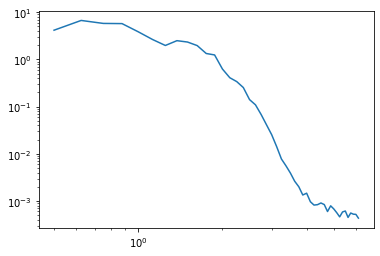

In [195]:
plt.loglog(masked_k_vector,resid1_spectrum)

### MAE GRF Loss

In [196]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid1_spectrum)

GRF_Loss_image_fitting_args=(GRF_seed,
                            get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
                            simulate_smooth_image_pure,model_loss_function,parameters,\
                            args_guess,learning_rate,max_iter,\
                            compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_image_fitting,*GRF_Loss_image_fitting_args)
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [197]:
loss_func(GRF_params);grad_loss_func(GRF_params)

[DeviceArray(0.75678362, dtype=float64, weak_type=True),
 DeviceArray(-0.02941864, dtype=float64, weak_type=True)]

In [317]:
hess_loss_func(GRF_params)

[[DeviceArray(1.79851709, dtype=float64),
  DeviceArray(-0.1251806, dtype=float64)],
 [DeviceArray(-0.1251806, dtype=float64, weak_type=True),
  DeviceArray(0.27325127, dtype=float64, weak_type=True)]]

In [318]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)
%timeit hess_loss_func(GRF_params)

297 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.38 s ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.5 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Seems that there are no chances to use hessian

In [332]:
#GRF_kwargs_losses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,GRF_Loss_pure,1)
GRF_kwargs_gradlosses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,jax.grad(GRF_Loss_pure),2)

#np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/GRF_kwargs_losses_grid_narrow.npy',GRF_kwargs_losses_grid_narrow)
np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/GRF_kwargs_gradlosses_grid_narrow.npy',GRF_kwargs_gradlosses_grid_narrow)


 11%|████▍                                     | 28/265 [11:53<1:40:37, 25.48s/it]

  3%|█▎                                        | 3/100 [08:45<4:43:02, 175.07s/it]


KeyboardInterrupt: 

In [ ]:
#GRF_kwargs_losses_grid_narrow=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/GRF_kwargs_losses_grid_narrow.npy',allow_pickle=True)
#GRF_kwargs_gradlosses_grid_narrow=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/GRF_kwargs_gradlosses_grid_narrow.npy',allow_pickle=True)

In [ ]:
A_array=GRF_Amps_array_narrow
Beta_array=GRF_Betas_array_narrow

GRF_kwargs_gradlosses_grid_narrow=np.zeros((100,100,2))

loss_grid=GRF_kwargs_losses_grid_narrow[:,:,0]
gradA_grid=GRF_kwargs_gradlosses_grid_narrow[:,:,0]
gradBeta_grid=GRF_kwargs_gradlosses_grid_narrow[:,:,1]

fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)
    

min_i,min_j=np.where(loss_grid==loss_grid.min())
im=sns.heatmap(ax=ax[0],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
sns.scatterplot(ax=ax[0],x=[50],y=[50],label='Ground truth')
sns.scatterplot(ax=ax[0],x=[min_j.item()],y=[min_i.item()],label='Fit value')
ax[0].legend(loc='lower left')

set_labels(im)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(gradA_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(gradBeta_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

#ax[1].set_yticks([])
#ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Optimization

In [ ]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=GRF_init_guess
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

In [ ]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

In [ ]:
np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/history.npy',history)
np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/loss_history.npy',loss_history)
np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/grads_history.npy',grads_history)
history=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/history.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/loss_history.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/grads_history.npy',allow_pickle=True)

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MSE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

### MSE GRF Loss

In [ ]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,resid1_spectrum)

GRF_Loss_image_fitting_args=(GRF_seed,
                            get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
                            simulate_smooth_image_pure,model_loss_function,parameters,\
                            args_guess,learning_rate,max_iter,\
                            compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_image_fitting,*GRF_Loss_image_fitting_args)
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [ ]:
loss_func(GRF_params);grad_loss_func(GRF_params)

In [ ]:
hess_loss_func(GRF_params)

In [ ]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)
%timeit hess_loss_func(GRF_params)

Seems that there are no chances to use hessian

In [ ]:
GRF_kwargs_losses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,GRF_Loss_pure,1)
GRF_kwargs_gradlosses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,jax.grad(GRF_Loss_pure),2)

np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/GRF_kwargs_losses_grid_narrow.npy',GRF_kwargs_losses_grid_narrow)
np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/GRF_kwargs_gradlosses_grid_narrow.npy',GRF_kwargs_gradlosses_grid_narrow)

In [ ]:
GRF_kwargs_losses_grid_narrow=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/GRF_kwargs_losses_grid_narrow.npy',allow_pickle=True)
GRF_kwargs_gradlosses_grid_narrow=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/GRF_kwargs_gradlosses_grid_narrow.npy',allow_pickle=True)

In [ ]:
A_array=GRF_Amps_array_narrow
Beta_array=GRF_Betas_array_narrow

loss_grid=GRF_kwargs_losses_grid_narrow[:,:,0]
gradA_grid=GRF_kwargs_gradlosses_grid_narrow[:,:,0]
gradBeta_grid=GRF_kwargs_gradlosses_grid_narrow[:,:,1]

fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)
    

min_i,min_j=np.where(loss_grid==loss_grid.min())
im=sns.heatmap(ax=ax[0],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
sns.scatterplot(ax=ax[0],x=[50],y=[50],label='Ground truth')
sns.scatterplot(ax=ax[0],x=[min_j.item()],y=[min_i.item()],label='Fit value')
ax[0].legend(loc='lower left')

set_labels(im)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(gradA_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(gradBeta_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

#ax[1].set_yticks([])
#ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Optimization

In [ ]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=GRF_init_guess
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

In [ ]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

In [ ]:
np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/history.npy',history)
np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/loss_history.npy',loss_history)
np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/grads_history.npy',grads_history)
history=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/history.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/loss_history.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/grads_history.npy',allow_pickle=True)

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MSE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

In [199]:
get_GRF=lambda GRF_seed: get_jaxified_GRF_pure(GRF_params,GRF_seed)

In [200]:
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+1+3)
GRFs=jax_map(get_GRF,GRF_seeds)

In [201]:
simulated_images=jax_map(simulate_perturbed_image_pure,GRFs)

In [206]:
def fit_simulated_image(simulated_image):
    model_loss_function_pure=purify_function(model_loss_function,simulated_image,parameters,simulate_smooth_image_pure)
    model_loss_grad=jax.grad(model_loss_function_pure)
    
    args_fit=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)
    fit_image=simulate_smooth_image_pure(parameters.args2kwargs(args_fit))
    return fit_image

In [207]:
q=fit_simulated_image(simulated_images[0])

In [208]:
q

DeviceArray([[0.0006675 , 0.00069622, 0.00073563, ..., 0.00195478,
              0.00186782, 0.00180382],
             [0.0006983 , 0.00072863, 0.00077026, ..., 0.00205162,
              0.00195915, 0.00189112],
             [0.00074059, 0.00077316, 0.00081787, ..., 0.00218502,
              0.00208488, 0.00201126],
             ...,
             [0.00144633, 0.00150847, 0.00159371, ..., 0.00215792,
              0.00203821, 0.00195098],
             [0.00137585, 0.00143418, 0.00151413, ..., 0.0020179 ,
              0.00190755, 0.00182708],
             [0.00132408, 0.00137963, 0.00145574, ..., 0.00191657,
              0.00181293, 0.00173731]], dtype=float64)

In [209]:
p=jax_map(fit_simulated_image,simulated_images)

In [210]:
p.shape

(3, 100, 100)

In [211]:
GRF_seeds

array([2, 3, 4])

In [309]:
GRF_Loss_image_fitting_pure(GRF_params)

DeviceArray(0.01102686, dtype=float64)

In [144]:
jax.grad(GRF_Loss_image_fitting_pure)(GRF_params)

[DeviceArray(1.33311669, dtype=float64, weak_type=True),
 DeviceArray(-0.05393537, dtype=float64, weak_type=True)]

In [67]:
loss_history

array([  0.42846601, 113.62199335, 121.1135082 , 122.14210868,
       122.14213275, 122.14215978, 122.14192563, 122.14212359,
       122.13840267, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14

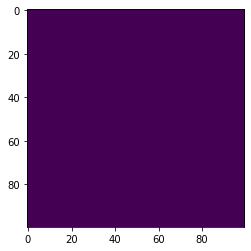

In [68]:
fit_history[-1]

array([ -5.59101055,   1.82798947,   1.54396848,   1.89074448,
        -5.47791982, -13.60370885,  -4.51103202,  10.7140463 ,
         2.72100865,  14.55350541,   2.26159905,  -6.32349972,
        -6.24592477,  -2.38124418])

In [58]:
fit_history.shape

(100, 14)

In [61]:
q=np.vectorize(model_loss_function_pure)(fit_history)

In [62]:
q.shape

(100, 14)

In [63]:
fit_history

array([[ 1.6       ,  0.15      , -0.04      , ..., -0.1       ,
         0.4       ,  0.15      ],
       [-5.21316887,  1.56564855,  1.78857258, ...,  0.21211834,
        -3.64593418,  4.2487072 ],
       [-5.21902999,  1.55632958,  1.79673005, ...,  0.27291455,
        -3.46120529,  4.2446362 ],
       ...,
       [-5.59101055,  1.82798947,  1.54396848, ..., -6.32349972,
        -6.24592477, -2.38124418],
       [-5.59101055,  1.82798947,  1.54396848, ..., -6.32349972,
        -6.24592477, -2.38124418],
       [-5.59101055,  1.82798947,  1.54396848, ..., -6.32349972,
        -6.24592477, -2.38124418]])